# CS156: Classification of Sunset Images

#### Executive Summary

In this project, we attempt to classify images as 'sunset' or 'not sunset' with the aim of choosing which photos could be posted to two different Instagram accounts. PCA was applied to the image data as a form of dimensionality reduction to improve runtime of model training and reduce overfitting. Logistic regression and SVM models were run on both PCA-transformed data (with $82$ principal components) and the original image data. These models were compared to a convolutional neural network (CNN) built on the pre-trained model MobileNetV2 with added dense and pooling layers trained on the original image data (and not the PCA-transformed data).

Out of various parameters for logistic regression models, SVM models and the CNN, it was found that the logistic regression model with a liblinear solver and C parameter of $0.0001$ produced the highest cross-validation score (used as a proxy for out-of-sample performance). The CNN produced the best actual out-of-sample performance on the test set; the precision score for the test dataset was found to be $92.8%$. The entire pipeline is shown in the flowchart below.

*Pipeline Overview*\
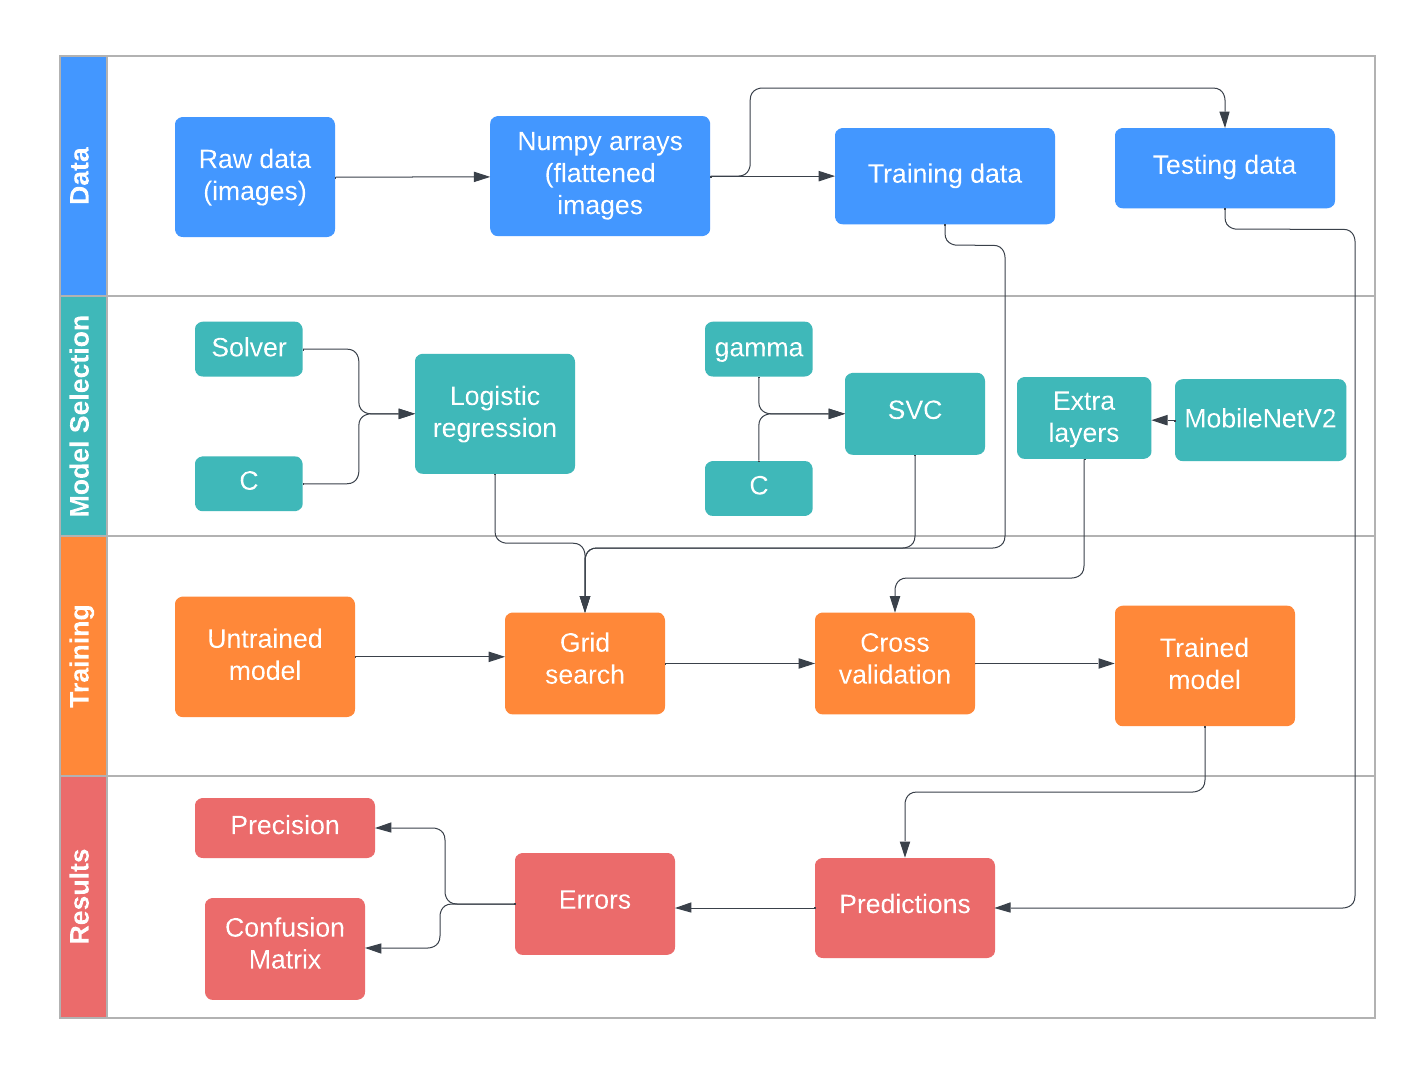

#### The Data

The aim of this project is to classify photos as 'sunset' or 'not sunset' to determine which images from my camera roll I should post to different Instagram accounts. Though I am not an avid social media participator, I do have two Instagram pages that I use occasionally. One of these is my personal account, where I post photos of me and my friends and family. The other I use to post pictures of sunsets. 

Included in this assignment are 154 photos from my Instagram accounts (55 from my personal account, and 96 from my sunset account) used as training data. I initially wanted to pull these directly from the accounts, however I didn't want to risk my privacy by making them public, and so I settled for downloading the images instead. Also included are 325 photos from my camera roll that were hand-selected by me as photos I would post on one of these Instagram pages (170 of these were non-sunset images, and the other 155 sunsets). The data is located in the google drive folder found [here](https://drive.google.com/drive/folders/1X3JPKB7GWRDcSg4tWTGnhnvnJxLTADjO?usp=sharing), separated into training & testing sets, and sunsets & non-sunsets.

All individuals included in the images have consented to being included in this assignment. Given that these are personal photos and that there are privacy concerns, the photo albums have only been shared with individuals with Minerva University emails who have the link included in this assignment. They have not been shared with individuals outside this circle. The insights from this assignment would only be used by myself, since the model is very specific to my situation and is only really applicable to my data (my photos). False positives could breach privacy in my case, since posting 'non-sunset' photos to a non-private Instagram account shares personal information with lots of people. This is discussed in more detail in the following sections.

This notebook can be run in google colab [here](https://drive.google.com/file/d/1MzBRbgltBL2Tq4e6SX3tscijnRzTuR4-/view?usp=sharing). Note that filepaths will need to be changed to those in the local drive.

#### Converting the Data to Python, Cleaning & Pre-Processing

To convert the data into a Python-readable format, we can use the OpenCV package. The method imread loads the images from a local filepath into a numpy array that contains a three-dimensional matrix of integers on the scale [0, 256] that represent the colour intensity of pixels. The first two dimensions represent the location of the pixel in the image, and the third the specific colour intensity (blue, green, and then red for OpenCV).

After loading the data into Python in the code block below, we then resize the images to be 100 by 100 pixels. We do this for a couple of reasons. Firstly, given that there are a lot of images in the datasets of high resolution (lots of pixels), we found that reducing this resolution had a significant impact on the runtime of the algorithm since there were fewer predictors in the model. Secondly, most of the images have different dimensions. Resizing them all to be square allowed each observation to have the same predictors, where one predictor is one coloured pixel.

Some of these resized images are displayed in the code cells below to give an example of the images to classify both from sunset/not sunset groups and testing/training sets. Since OpenCV reads colours in the order BGR, and matplotlib assumes inputs of the format RGB, we can use the method COLOR_BGR2RGB to perform swaps between the pixels.

We then flattened these arrays to produce a one-dimensional array for each image/observation. The coloured pixels were kept as predictors in the model. This is because colour could be an integral factor in identifying an image as a sunset (perhaps my choice of a sunset photo is partly because of the colours in the sky). After flattening the array, each image had $100.100.3=30,000$ predictors.

In [1]:
#import google driver - addition from submission to load images in colab
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_images_from_file(paths, show_idxs = [], resize = 224):
    """
    Function retrieves images from local file paths, resizes the images, and flattens them into a 1-dimensional 
    array. The resized images can be displayed using the show_idxs attribute.
    
    Parameters
    ----------
    paths: lst
        List of paths of local files containing images to be read.
    show_idxs: lst
        List of index locations of the resized images to be displayed.
    resize: int
        The pixel dimensions used to resize all images.
        
    Returns
    -------
    X: lst
        List of numpy arrays of image attributes (integers on scale [0, 256] representing RGB colour intensities for 
        each pixel) taken from resized flattened images.
    y: lst
        List of labels from 0 to len(paths)-1. In the case of binary classification, this is a list of 0s and 1s
        corresponding to the locations of the flattened images in X.
    """
    
    X = []
    y = []
    
    # loops over the paths then filenames where data is located
    for i, path in enumerate(paths):
        for j, filename in enumerate(os.listdir(path)):
            
            # skip over filenames that are not images
            if filename == '.ipynb_checkpoints':
                continue
                
            # read and resize images
            img = cv2.imread(os.path.join(path, filename))
            if img is None:
                continue
            resized_img = cv2.resize(img, dsize = (resize, resize))
            
            # display a portion of loaded resized images
            if j in show_idxs:
                
                # change colour order of images from OpenCV (BGR) -> matplotlib (RBG)
                rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
                plt.matshow(rgb_img)
                plt.show()
            
            # flatten image objects to array of ints on scale [0, 256]
            X.append(resized_img.flatten())
            y.append(i)

    return X, y

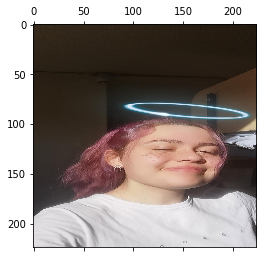

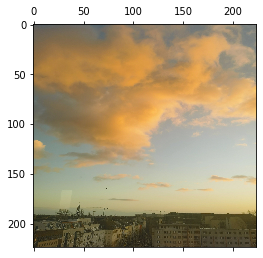

In [3]:
# load training data - paths changed for google drive
path_train_not_sunsets = '/content/drive/MyDrive/CS156_Assignment/train/not_sunsets'
path_train_sunsets = '/content/drive/MyDrive/CS156_Assignment/train/sunsets'

X_train, y_train = get_images_from_file([path_train_not_sunsets, path_train_sunsets], [30])

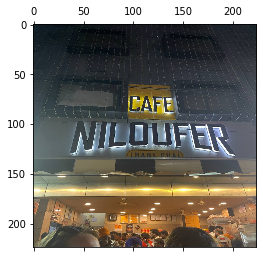

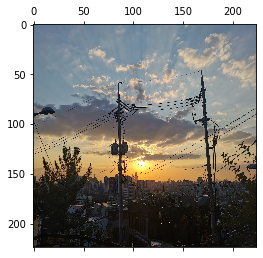

In [4]:
# load testing data
path_test_not_sunsets = '/content/drive/MyDrive/CS156_Assignment/test/not_sunsets'
path_test_sunsets = '/content/drive/MyDrive/CS156_Assignment/test/sunsets'

X_test, y_test = get_images_from_file([path_test_not_sunsets, path_test_sunsets], [30])

#### Dimensionality Reduction

Given that there are $30,000$ features/predictors and only $149$ samples in the training set as above, it might be necessary to do some dimensionality reduction. This issue is known as the curse of dimensionality, which refers to the challenge of effectively capturing the underlying structure of high-dimensional data. As the number of features increases, the amount of data required to obtain a meaningful representation of the data also grows exponentially, resulting in a data-rich but information-poor scenario.

When there are more features than samples, the dataset becomes highly dimensional, making it challenging to interpret and analyse since datapoints are far apart. Additionally, having too many features can cause overfitting, making the model less generalisable to new, unseen data. In other words, an overfitted model may perform well on the training data but poorly on new data, as it has not learned the underlying features of 'sunsets' and 'non-sunsets' but rather memorised the training set. Finally, when there are so many features, models can take a very long time to train.

To address these issues, dimensionality reduction techniques like PCA aim to reduce the number of features in the dataset while retaining as much of the original information as possible. This is achieved by transforming the original features into a smaller set of linearly uncorrelated variables known as principal components. These principal components capture the most important patterns and variations in the data, allowing for a simplified and more interpretable representation of the data.

Though we can easily perform PCA using sklearn, we can outline the steps in pseudocode as follows:
1. **Compute the covariance matrix**: The covariance matrix displays the associations between variable pairs. Compute it by centering the data around the mean and multiplying the transpose of the data matrix by the data matrix itself.
2. **Compute the eigenvectors and eigenvalues**: Use a linear algebra library or tool to obtain the eigenvectors and eigenvalues of the covariance matrix. These values provide information about the primary components of the data.
3. **Sort the eigenvectors based on their corresponding eigenvalues**: Arrange the eigenvectors in decreasing order of their corresponding eigenvalues. The eigenvectors with the highest eigenvalues capture the most variance in the data.
4. **Select the number of principal components**: Choose the number of principal components to use by examining a scree plot that graphs the explained variance for each principal component. Pick the principal components that account for most of the variance in the data. In some cases, we might prefer to use later principal components that explain less variance but are more feature-specific or utilize a cutoff to understand the amount of noise in the data.
5. **Calculate the loading scores**: The loading scores reveal how much each variable contributes to each principal component. To calculate the loading scores for the kth principal component and the jth variable, take the dot product between the jth column of the centered data matrix (i.e., the variable data) and the kth eigenvector. This gives the covariance between the variable and the principal component, which is then divided by the square root of the kth eigenvalue (representing the variance explained by the kth component).
6. **Compute the principal component scores**: The principal component scores show the data point values along each principal component. Compute the scores by projecting the data onto the eigenvectors (multiplying the data matrix by the sorted eigenvectors).
7. **Interpret the results if required**: Analyze the loading scores and principal component scores to identify strongly related variables and groups of similar data points. Skip this step if the primary goal is to reduce dimensionality and use the PCs for a model.
8. **Perform a reverse transform**: If necessary, transform the data back to its original basis to display it. Multiply the compressed values (i.e., the data in the PC basis) by the loading scores (i.e., the coefficients of the principal components) and add the mean of the original data.


Given that there are $149$ samples in our training set, we will perform PCA using the first $100$ principal components (PCs) and determine how much variance each PC explains. Visualising scree plots (both cumulative and not), we see that the change in explained variance after the first ~$10$ PCs is significant. After the $10$th PC, the amount of variance explained is very small for each subsequent component. However, on the right plot, we see that $10$ PCs actually only explains ~$65%$ of the variance in our image data. Thus, we want to use more PCs to explain more variance. We might make this decision by choosing the number of PCs that allows us to explain $95%$ of the variance in the data ($82$ PCs). 

Plotting a sample of images (one sunset and one non-sunset, the original images of which are above), we see that at ~$80$ PCs, the image resembles the original well. Less than this and there is still a significant amount of noise. $82$ therefore seems like a good choice of PCs to use in our model going forward. This significantly reduces the number of predictors from $30,000$ to $82$, which should have a large impact on the runtime of the models.

Number of components required to explain 95% variance: 82


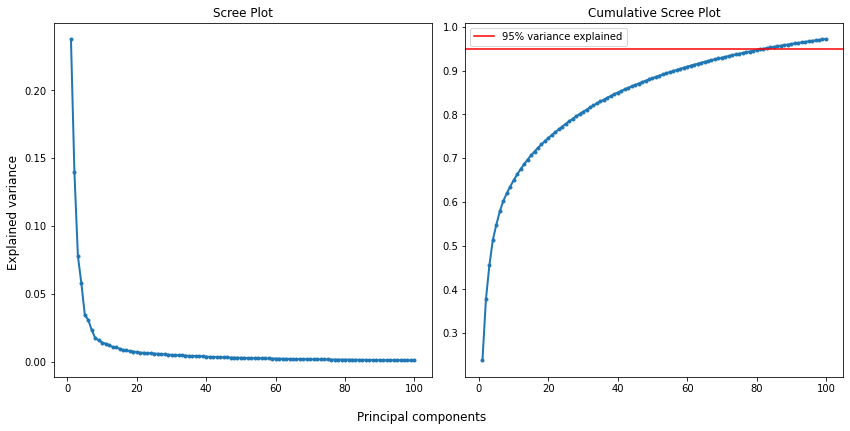

In [5]:
from sklearn.decomposition import PCA

def pca_scree_plot(X_train, components = 100):
    """
    Generates scree plots (cumulative and not) for PCA and calculates the number 
    of components required to explain 95% variance in the data.

    Parameters
    ----------
    X_train : array-like of shape (n_samples, n_features)
        Input data matrix.

    components : int, optional (default=100)
        Number of components to use for PCA.

    Returns
    -------
    None
    """
    # perform PCA on data
    pca = PCA(n_components = components)
    pca.fit(X_train)

    # calculate cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # find number of components required to explain 95% variance
    n = np.argmax(cumulative_variance_ratio >= 0.95) + 1
    print("Number of components required to explain 95% variance:", n)

    # scree plots (cumulative and not)
    fig, ax = plt.subplots(1, 2, figsize = (12, 6), sharex = True)
    ax[0].plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker = '.', linewidth=2)
    ax[0].set_title('Scree Plot')
    ax[1].plot(range(1, pca.n_components_ + 1), cumulative_variance_ratio, marker = '.', linewidth=2)
    ax[1].set_title('Cumulative Scree Plot')
    ax[1].axhline(0.95, color = 'red', label = '95% variance explained')
    ax[1].legend()
    fig.supxlabel('Principal components')
    fig.supylabel('Explained variance')
    fig.tight_layout()
    plt.show()

pca_scree_plot(X_train)

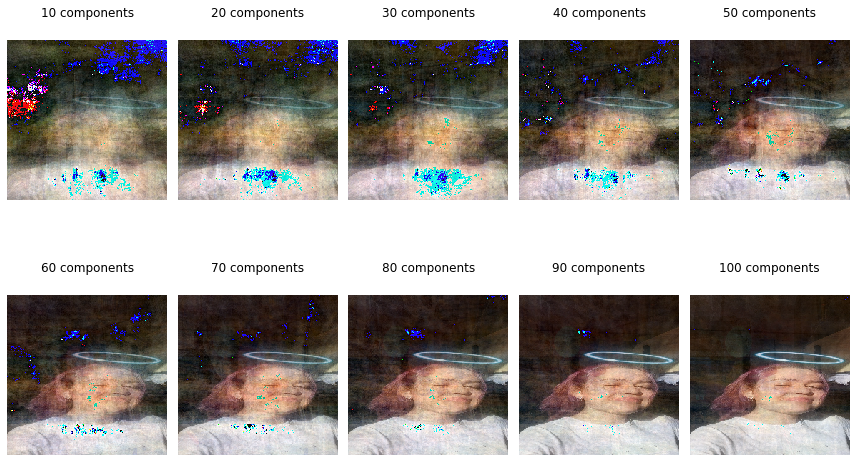

In [6]:
def plot_reconstructed_pca(idx_to_plot):
    """
    Plot reconstructed images using principal component analysis (PCA).
    This function computes PCA with varying number of principal components (PCs),
    and uses the resulting model to project and reconstruct the input image. The
    reconstructed image is then displayed in a plot, along with the number of PCs
    used for the reconstruction.

    Parameters
    ----------
    idx_to_plot : int
        Index of the image to be reconstructed and plotted.

    Returns
    -------
    None
    """
    # plot images with varying number of PCs
    fig, axes = plt.subplots(2, 5, figsize=(12, 8))
    fig.subplots_adjust(hspace=0, wspace=0.05)
    components = range(10, 101, 10)

    for i, ax in enumerate(axes.flat):
        pca = PCA(n_components = components[i])
        
        # project and reconstruct image
        X_proj = pca.fit_transform(X_train)
        X_reconstructed = pca.inverse_transform(X_proj)
        image = X_reconstructed[idx_to_plot].reshape(224, 224, 3)
        ax.matshow(cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2RGB))
        ax.set_title(f'{components[i]} components')
        ax.axis('off')
        
    fig.tight_layout()
    plt.show()

plot_reconstructed_pca(30)

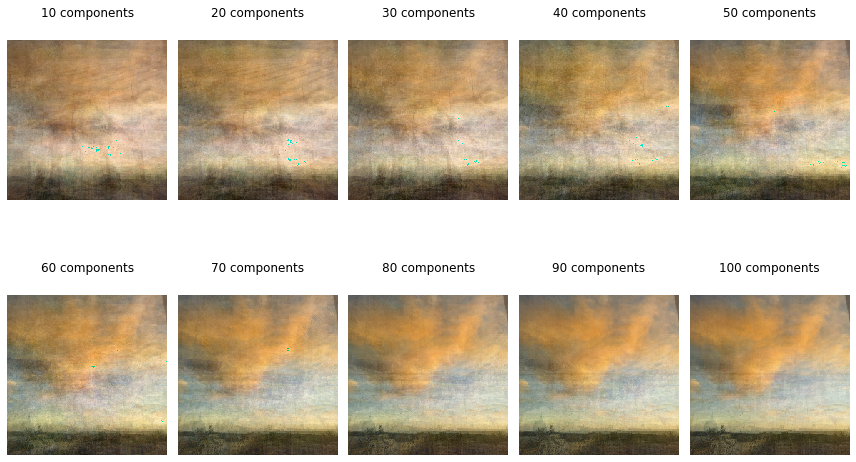

In [7]:
plot_reconstructed_pca(84)

In [8]:
# pca with chosen number of PCs
pca = PCA(n_components = 82)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

We can also visualise the first three components of the PCA on a 3-dimensional plot as below (unfortunately, 82 dimensions is not possible). Here, we see that there are two distinct groups where sunset/non-sunset images live in the space. However, we also see that there is some overlap between the groups. Extra dimensions might ensure that these groups are linearly separable.

In [9]:
import plotly.express as px
import pandas as pd

def pca_component_plot_3d(pca_transformed_data):
    """
    Plot a 3D scatter plot of PCA-transformed data with labeled classes.
    This function creates a 3D scatter plot of the first three principal components
    of the input data, with the points colored by their class labels. The class labels
    are assumed to be in the variable `y_train`, and are mapped to the labels 'Not sunset'
    and 'Sunset' for visualisation purposes. This function uses the Plotly library for
    visualisation.

    Parameters
    ----------
    pca_transformed_data : numpy.ndarray
        The transformed data after applying PCA. The array should have three columns,
        representing the values of the first three principal components.

    Returns
    -------
    None
    """
    df = pd.DataFrame(pca_transformed_data)
    df['label'] = y_train
    df['label'] = df['label'].replace([0, 1], ['Not sunset', 'Sunset'])
    df.rename(columns = {0:'PC1', 1:'PC2', 2:'PC3'}, inplace = True)
    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
                color='label', title = 'PC1, PC2, and PC3 of Sunset Data')
    fig.show()

pca_component_plot_3d(X_train_pca)

#### The Task: Classification

The tasks here is to classify the images as either sunset or not sunset. Since there are only two categories, this is a binary classification problem.

The test set here is not taken as a random sample from the training data since it will be more valuable to see how the model performs on new data, and to report metrics on a new set of data that represents the models performance on real-world examples. The model will be optimised on the training data using cross validation, and metrics reported on the test data.

#### Model Selection

I will use three different classification models for this task, logistic regression, SVC, and a CNN built on the pre-trained network MobileNetV2.

*Logistic Regression*\
Logistic regression works by fitting a sigmoid function to the data as follows:

<ol> 
    <li> Initialise the model parameters:
$weights = [0, 0, ..., 0]$ (one weight for each predictor, initialised to 0) and
$bias = 0$.</li>
    <li> Define the logistic function:
$sigmoid(x) = \frac{1}{1 + e^{-x}}$.</li>
    <li> For each iteration of the training process:
    <ol>
        <li> Calculate the weighted sum of the predictors and the bias:
$z = \sum\limits_{i=1}^{n} weights_i \cdot X_i + bias$, where $n$ is the number of predictors ($30,000$ in this case).</li>
        <li> Pass the weighted sum through the logistic function to get the predicted probability of the image being of a sunset (positive class):
$prediction = sigmoid(z)$.</li>
        <li> Calculate the error between the predicted probability and the actual label:
$error = y - prediction$.</li>
        <li> Update the weights and bias based on the error and a learning rate ($\alpha$):
$weights_i = weights_i + \alpha \cdot error \cdot X_i$ and
$bias = bias + \alpha \cdot error$.</li></ol>
    <li> Repeat step 3 until the model has converged (the error doesn't signficiantly change over a number of iterations) or a maximum number of iterations has been reached.</li>
    <li> After the model has been trained, new data can be input and the predicted probabilities can be calculated using the logistic function and the final weights and bias.</li>
</ol>

In scikit-learn, the logistic regression implementation uses an optimisation algorithm, such as liblinear or lbfgs, to find the optimal weights that minimise the cost function instead of the iterative approach outlined above. This allows for a more efficient and scalable solution, especially when the number of predictors is large as in this case. Additionally, scikit-learn's logistic regression implementation also uses an 'L2' penalty that is added to the cost function to prevent overfitting.

*SVC*\
Support-vector classifications works by creating a hyperplane in high-dimensional space that separates the data belonging to sunset and non-sunset groups as follows:
<ol>
    <li> Initialise the parameter $C$, which determines the trade-off between achieving a low training error and a low testing error, and the kernel function, which transforms the flattened image data into a higher-dimensional space where a linear boundary can better separate the classes, sunset and not sunset.</li>
    <li> Train the SVM model by solving the following optimisation problem:
$$\min_{w, b, \xi} \frac{1}{2}|w|^2 + C \sum_{i=1}^{n} \xi_i$$

Subject to the constraints:
$$y_i(w^Tx_i + b) \geq 1 - \xi_i$$
$$\xi_i \geq 0$$

where $w$ is the weight vector, $b$ is the bias term, $\xi_i$ is the slack variable for the $i^{th}$ training example $(x_i, y_i)$, and $C$ is the regularisation parameter. The optimisation problem is aimed to find the optimal values for $w$, $b$, and $\xi_i$ that maximises the margin between the hyperplane (defined by $w$ and $b$) and the closest data points (support vectors) while still accommodating some misclassified examples through the use of slack variables.</li>
    <li> Use the obtained hyperplane parameters $w$ and $b$ to make predictions on new data by computing the dot product of the feature representation $\phi(x)$ of a new example $x$ and the weight vector $w$, plus the bias $b$. The sign of the result determines the predicted class label.</li>
</ol>

*CNN Built on MobileNetV2*\
MobileNetV2 is a pre-trained model that has been widely used for large-scale image classification. This model is suitable as a base model for binary classification problems like identifying whether an image is a sunset or not. It has already learned to extract high-level features from millions of images with thousands of labels, and it has achieved high accuracy on the MobileNetV2 benchmark, indicating that it can generalise well and perform accurately on a range of tasks. In addition, MobileNetV2 was trained on a diverse dataset of over a million images, which includes many different categories, such as animals, vehicles, and natural scenes which means that it should contain the necessary features to categorise sunsets. Using a pre-trained model like MobileNetV2 allows us to save time and resources. This capability, combined with its high accuracy and diverse training data, makes MobileNetV2 an ideal choice for binary classification tasks like identifying sunset images.

Using a pre-trained model like MobileNetV2 also helps to prevent overfitting when training a model on a smaller dataset for a specific task. This can happen when there are too few examples in the training set, or when the model is too complex for the task at hand. By starting with a pre-trained model, the model has already learned to recognise common features and patterns, which allows it to focus on learning the specific features that are important for the binary classification task. This can lead to better generalisation and prevent the model from overfitting to the training data.

The CNN model architecture is based on the MobileNetV2 convolutional neural network architecture. It takes as input an image of size $224 . 224 . 3$ and produces a single output representing whether the image is a sunset or not. The MobileNetV2 architecture consists of multiple layers of convolutional and pooling layers followed by a few fully connected layers. In this model, the MobileNetV2 architecture is used as a base model with its top layers (fully connected layers) removed. The output of the base model is then fed into a global average pooling layer, followed by a fully connected layer with $1024$ units and a ReLU activation function, and a dropout layer with a dropout rate of $0.5$. The output of the dropout layer is then fed into another fully connected layer with $512$ units and a ReLU activation function. Finally, a single neuron output layer is added with no activation function. The entire model is trained using the binary cross-entropy loss function and the Adam optimizer with a learning rate of $0.0001$. The layers of the base model are frozen to prevent overfitting, while the additional layers are trained to learn features specific to the binary sunset classification task.

The purpose of the $512$ ReLU fully-connected layer in the model is to perform dimensionality reduction and learn higher-level features specific to the binary sunset classification task. The output of the global average pooling layer is a fixed-size feature map, which is then fed into a fully-connected layer with $1024$ units and a ReLU activation function. This layer performs feature extraction from the feature map produced by the base model. However, since the number of units in this layer is large, it can lead to overfitting, especially when the training dataset is small. Therefore, another fully-connected layer with $512$ units and a ReLU activation function is added to perform dimensionality reduction and to capture more important and relevant features specific to the binary sunset classification task. The ReLU activation function helps to introduce non-linearity in the output of this layer, which can increase the model's expressive power and improve its ability to learn complex features.

During the training process, the forward pass is used to compute the output of the model given an input. In this case, the input is an image, and the output is a prediction of whether the image is a sunset or not. The forward pass involves passing the input through the layers of the model to compute the output. 

The backpropagation algorithm is used to compute the gradients of the loss function with respect to the parameters of the model, which are used to update the parameters during the optimisation process. In this case, the loss function is binary cross-entropy, which measures the difference between the predicted probability of the image being a sunset and the true label. During the backpropagation step, the gradients of the loss function with respect to the parameters of the model are computed using the chain rule of calculus. These gradients are then used to update the parameters of the model in the opposite direction of the gradient, with the aim of minimising the loss function.The parameters that are updated during backpropagation are the weights and biases of the dense layers added on top of the pre-trained MobileNetV2 base model. The pre-trained weights in the base model are kept frozen during training, as they have already been trained on a large dataset and are considered useful features for the task of sunset classification.

#### Training the Model

To train the logistic regression and SVC models, the data is split into five folds, and a grid search is completed to find the optimal classifier (logistic regression versus SVC) and respective parameters. For logistic regression, the hyperparameters to tune include C, a regularisation term to reduce overfitting, and the solver, the algorithm used to find the optimal weights and bias that minimise the cost function. For SVC, the hyperparameters to tune include C (same definition as for logistic regression), and gamma, a parameter that determines the flexibility of the decision boundary.

For each fold, the data is fitted on the remaining four folds, and the validation precision is measured on the final fold that was left out. The validation performance is given as a mean of these five values. This mean precision is calculated for each set of parameters as above. The cross-validation performed here helps to prevent overfitting by ensuring the model does not tune to specific features of the images that aren't generalisable to all potential images that would be run through the model.

Precision is used in this analysis due to the cost of identifying an image as a sunset when it is not. I don't mind if an image of a sunset is shared on my personal Instagram account (false negative), however sharing an image of myself on my sunset page (false positive), which is public, could severely breach my privacy. I only care about false positives and use precision, which gives the proportion of correctly-classified sunset images to all images that are classified as sunsets, as the optimisation target. 

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV

def logreg_svc_CV(X_train, y_train):
    """
    Completes grid search cross validation on logistic regression models with varying C and solver parameters, and SVC
    with varying C and gamma parameters. For each of 5 folds, the model is fit on 4/5, the other being reserved for 
    measuring precision. GridSearchCV does this for all classifier/parameter combinations and returns an object
    containing the results for each combination, including precisions for each fold of the CV.
    
    Parameters
    ----------
    X_train: lst
        Nested list of predictors for each observation. In the case of sunset classification, this is a list of image 
        attributes (integers on scale [0, 256] representing RGB colour intensities for each pixel).
    y_train: lst
        List of labels, the targets of the classification (0: not sunset, 1: sunset).
        
    Returns
    -------
    gs: GridSearchCV obj
        An object containing the results for each combination, including precisions for each fold of the CV.
    """
    
    # number of folds for CV
    kfold = KFold(n_splits = 5, random_state = 123, shuffle = True)
    
    clf_logreg = LogisticRegression(random_state = 123, max_iter = 1000)
    clf_svc = SVC(random_state = 123)

    # hyperparameters to optimise over for logistic regression
    param_logreg = {
        'classifier': [clf_logreg],
        'classifier__C': np.power(10.0, np.arange(-4, 5)),
        'classifier__solver': ['liblinear', 'lbfgs', 'sag', 'saga']
    }

    # hyperparameters to optimise over for SVC
    param_svc = {
        'classifier': [clf_svc],
        'classifier__C': np.power(10.0, np.arange(-4, 5)),
        'classifier__gamma': np.power(10.0, np.arange(-4, 1))
    }
    
    pipeline = Pipeline([('classifier', clf_logreg)])
    param_grid = [param_logreg, param_svc]

    # fit for different parameters & models, for each of k folds
    gs = GridSearchCV(pipeline, param_grid = param_grid, scoring = 'precision', cv = kfold, n_jobs = -1, verbose = 3)
    gs.fit(X_train, y_train)
    
    print('Best parameters:', gs.best_params_)
    
    return gs

In [11]:
gs_pca = logreg_svc_CV(X_train_pca, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'classifier': LogisticRegression(C=0.0001, max_iter=1000, random_state=123,
                   solver='liblinear'), 'classifier__C': 0.0001, 'classifier__solver': 'liblinear'}


In [12]:
# load images with lower resolution and train
X_train_reduced, y_train_reduced = get_images_from_file([path_train_not_sunsets, path_train_sunsets], resize = 100)
X_test_reduced, y_test_reduced = get_images_from_file([path_test_not_sunsets, path_test_sunsets], resize = 100)
gs_original = logreg_svc_CV(X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'classifier': LogisticRegression(C=0.0001, max_iter=1000, random_state=123), 'classifier__C': 0.0001, 'classifier__solver': 'lbfgs'}


In [13]:
import seaborn as sns

def plot_gs_results(df_gs, params1, params2, model1, model2, title):
    """
    Plots the results of precision scores from gridsearch dataframe. The function creates two subplots, one containing
    the results for the first model based on two chosen parameters, and the other the results of the second model based
    on two chosen parameters (can be the same of different features).
    
    Parameters
    ----------
    df_gs: df
        Dataframe containing the results from a GridSearchCV object.
    params1: lst
        List of parameters to plot on subplot one. The first element of the list is the x axis, the second the y axis, and
        the third the hue.
    params2: lst
        List of parameters to plot on subplot two. The first element of the list is the x axis, the second the y axis, and
        the third the hue.
    model1: str
        The name of the classifier used for subplot one.
    model2: str
        The name of the classifier used for subplot two.
    title: str
        Extension of the title specifying which input data.
    
    Returns
    -------
    None
    """
    
    # initialise plots and plot params for each model
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
    sns.scatterplot(data = df_gs, x = params1[0], y = params1[1], hue = params1[2], ax = ax[0])
    sns.scatterplot(data = df_gs, x = params2[0], y = params2[1], hue = params2[2], ax = ax[1])
    
    # rescale axis to display C at regular intervals
    ax[0].set_xscale('log')
    ax[1].set_xscale('log')
    ax[0].set_title(model1)
    ax[1].set_title(model2)
    fig.suptitle('Precision Scores for Different Models and Parameters with '+title)
    fig.tight_layout()
    plt.show()

Plotting the results as below for the PCA-transformed image data input, we see that logistic regression does a much better job in terms of precision score. The optimal model is the one that uses the solver 'liblinear' and a C value of 0.0001.

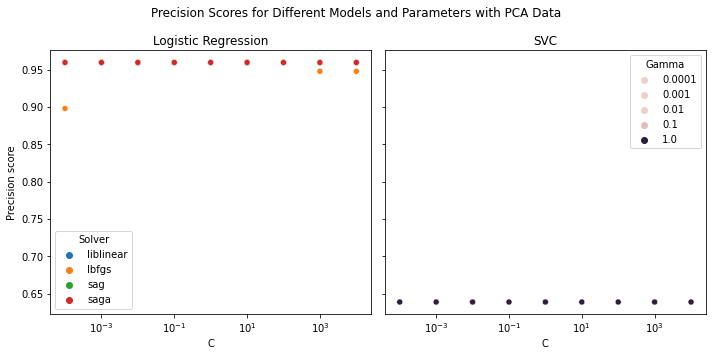

In [14]:
# convert grid search results to df, and rename columns for plotting
df_gs_pca = pd.DataFrame(gs_pca.cv_results_)
df_gs_pca.rename(columns={'param_classifier__C':'C', 'mean_test_score':'Precision score', 
                      'param_classifier__solver':'Solver', 'param_classifier__gamma': 'Gamma', 
                      'param_classifier': 'Model'}, inplace=True)

plot_gs_results(df_gs_pca, ['C', 'Precision score', 'Solver'], ['C', 'Precision score', 'Gamma'], 
                'Logistic Regression', 'SVC', 'PCA Data')

Plotting the results as below for the original image data input, we see that logistic regression does a much better job in terms of precision score. The optimal model is the one that uses the default solver 'lbfgs' and a C value of 0.0001.

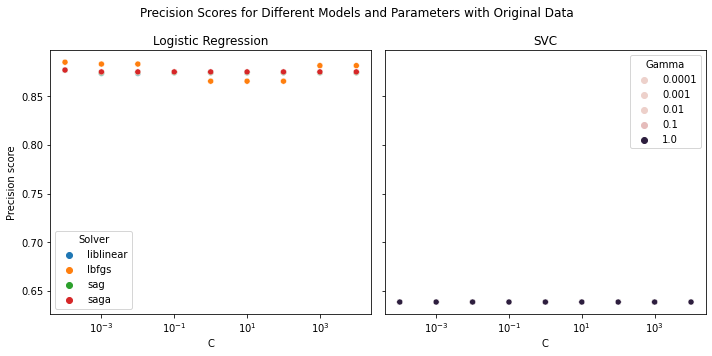

In [15]:
# convert grid search results to df, and rename columns for plotting
df_gs_original = pd.DataFrame(gs_original.cv_results_)
df_gs_original.rename(columns={'param_classifier__C':'C', 'mean_test_score':'Precision score', 
                      'param_classifier__solver':'Solver', 'param_classifier__gamma': 'Gamma', 
                      'param_classifier': 'Model'}, inplace=True)

plot_gs_results(df_gs_original, ['C', 'Precision score', 'Solver'], ['C', 'Precision score', 'Gamma'], 
                'Logistic Regression', 'SVC', 'Original Data')

To train the CNN model built on MobileNetV2, we can also complete cross-validation with five folds (as above). For each fold, the model is trained on the remaining four folds, and validation scores calculated on the final fold. It is important to note that only the added layers are trained here, and not the pre-trained layers.

Fine-tuning was also attempted, however, even after trying out a range of different learning rates and number of fine-tuning layers, the validation metrics did not improve. This step was computationally expensive for no gain, which is why it isn't included in this notebook.

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import metrics

def mobilenet_cv(X_train, y_train, X_test, y_test, k = 5, lr = 0.0001):
    """
    Perform K-Fold Cross-Validation on a MobileNetV2 model.

    Parameters
    ----------
    X_train : lst
        The training input data.
    y_train : lst
        The target training data.
    X_test : lst
        The testing input data.
    y_test : lst
        The target testing data.
    k : int, optional
        The number of folds to use for cross-validation. Defaults to 5.
    lr : float, optional
        The learning rate of the new model layers. Defaults to 0.0001.

    Returns
    -------
    tuple of list of floats
        A tuple of metric scores for each fold of the cross-validation.
        The first element is a list of accuracy scores.
        The second element is a list of validation accuracy scores.
        The third element is a list of loss scores.
        The fourth element is a list of validation loss scores.
        The fifth element is a list of precision scores.
        The sixth element is a list of validation precision scores.
        The seventh element is a list of AUC scores.
        The eighth element is a list of validation AUC scores.
    """
    tf.random.set_seed(42)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # reshape the entire dataset first
    X_train_reshaped = np.array(X_train).reshape(-1, 224, 224, 3)
    X_test_reshaped = np.array(X_test).reshape(-1, 224, 224, 3)

    acc, val_acc, loss, val_loss, prec, val_prec, auc, val_auc = [], [], [], [], [], [], [], []

    for fold, (train_indices, val_indices) in enumerate(kf.split(X_train)):
        # split data into train and validation sets
        x_train_fold = X_train_reshaped[train_indices]
        y_train_fold = np.array(y_train)[train_indices]
        x_val_fold = X_train_reshaped[val_indices]
        y_val_fold = np.array(y_train)[val_indices]

        # create a new model with added layers
        base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.5)(x)

        # added dimensionality reduction
        x = Dense(512, activation='relu')(x) 
        predictions = Dense(1)(x)
        model = Model(inputs=base_model.input, outputs=predictions)

        # freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # compile the model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                    metrics=[metrics.BinaryAccuracy(name='accuracy'),
                        metrics.Precision(name='precision'),
                        metrics.AUC(name='auc')])

        # train the model on the current fold
        history = model.fit(x_train_fold, y_train_fold, epochs=10, batch_size=32, 
                            validation_data=(x_val_fold, y_val_fold), verbose = 0)

        # record metric scores
        acc.append(history.history['accuracy'])
        val_acc.append(history.history['val_accuracy'])
        loss.append(history.history['loss'])
        val_loss.append(history.history['val_loss'])
        prec.append(history.history['precision'])
        val_prec.append(history.history['val_precision'])
        auc.append(history.history['auc'])
        val_auc.append(history.history['val_auc'])

    return acc, val_acc, loss, val_loss, prec, val_prec, auc, val_auc

In [17]:
def plot_mobilenet_cv(acc, val_acc, loss, val_loss, prec, val_prec, auc, val_auc):
    """
    Plot training and validation metrics for a MobileNet model trained with cross-validation.
    This function creates a 1x4 grid of subplots, where each subplot corresponds to one of the metrics
    (accuracy, loss, precision, and AUC). For each metric, the function plots the mean score across
    the K cross-validation folds for both training and validation, along with the 95% confidence
    interval obtained by computing the 2.5th and 97.5th percentiles of the scores across folds at each epoch.
    The x-axis of the plot corresponds to the number of training epochs (T), while the y-axis corresponds
    to the value of the metric.

    Parameters
    ----------
    acc : lst
        Training accuracy scores for K cross-validation folds and T epochs.
    val_acc : lst
        Validation accuracy scores for K cross-validation folds and T epochs.
    loss : lst
        Training loss values for K cross-validation folds and T epochs.
    val_loss : lst
        Validation loss values for K cross-validation folds and T epochs.
    prec : lst
        Training precision scores for K cross-validation folds and T epochs.
    val_prec : lst
        Validation precision scores for K cross-validation folds and T epochs.
    auc : lst
        Training AUC scores for K cross-validation folds and T epochs.
    val_auc : lst
        Validation AUC scores for K cross-validation folds and T epochs.

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(1, 4, figsize = (15, 5))

    labels = ['Accuracy', 'Loss', 'Precision', 'AUC']
    for i, metric in enumerate([[acc, val_acc], [loss, val_loss], [prec, val_prec], [auc, val_auc]]):
        ax[i].plot(np.mean(metric[0], axis = 0), label='Training')
        ax[i].fill_between(range(10), np.percentile(metric[0], 2.5, axis = 0), np.percentile(metric[0], 97.5, axis = 0), alpha = 0.3)
        ax[i].plot(np.mean(metric[1], axis = 0), label='Validation')
        ax[i].fill_between(range(10), np.percentile(metric[1], 2.5, axis = 0), np.percentile(metric[1], 97.5, axis = 0), alpha = 0.3)
        ax[i].legend()
        ax[i].set_title(labels[i])

    fig.suptitle('Training and Validation Metrics Across Training Epochs')
    fig.supxlabel('Epoch')
    fig.tight_layout()
    plt.show()

We can plot the validation and training metrics across all folds (with means and 95% confidence intervals of the data). This shows that loss decreases across the epochs, and accuracy, precision, and AUC scores all increase. This indicates that our model is working as expected. It also shows that we don't need to continue training the model (i.e. using a larger number of epochs), since that validation scores have already begun to plateau (they likely wouldn't improve if we increased the number of epochs).

Precision Validation Score: 0.882


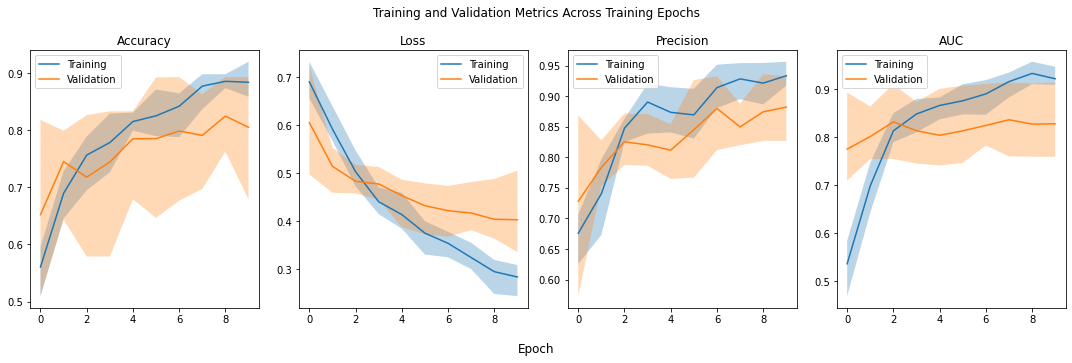

In [18]:
acc, val_acc, loss, val_loss, prec, val_prec, auc, val_auc = mobilenet_cv(X_train, y_train, X_test, y_test)
print('Precision Validation Score:', round(np.mean(val_prec, axis = 0)[-1], 3))
plot_mobilenet_cv(acc, val_acc, loss, val_loss, prec, val_prec, auc, val_auc)

We might also try cross-validation with a different learning rates, given that this can affect the performance of the model. Above we used 0.0001. Below we will also try varying learning rates between 0.001 and 0.0001 to determine the impact this has on model performance (validation metrics specifically). Given that we care most about precision, as explained above, we should optimise the learning rate for the highest validation precision score.

Below, we complete a gridsearch over some possible learning rates to determine the optimal value. The model appears to converge onto a similar precision validation score regardless of the learning rate. This means that we can choose any learning rate between 0.001 and 0.0001 and should get similar results.

Best precision score was 0.913 with a learning rate of 0.0005.


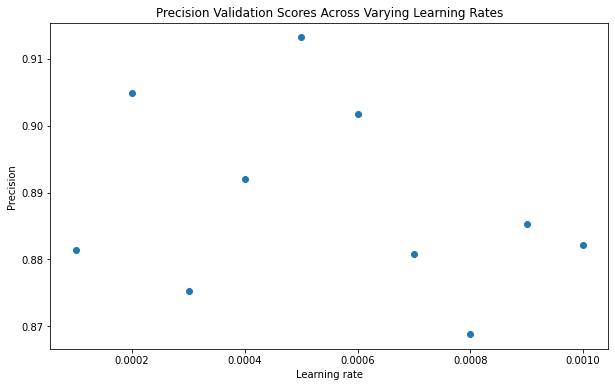

In [19]:
def grid_search_lr(X_train, y_train, X_test, y_test):
    """
    Perform a grid search to find the best learning rate for a MobileNet model using cross-validation.
    This function performs a grid search over a range of learning rates (from 0.0001 to 0.001) and
    selects the learning rate that produces the highest precision score on the validation set, as
    measured by cross-validation using a MobileNet model. The function plots the precision validation
    scores for each learning rate and returns the best learning rate found.

    Parameters
    ----------
    X_train : lst
        The training input data.
    y_train : lst
        The target training data.
    X_test : lst
        The testing input data.
    y_test : lst
        The target testing data.

    Returns
    -------
    best_lr : float
        The best learning rate found during the grid search.
    """
    # test learning rates between 0.001 and 0.0001
    learning_rates = [i/10000 for i in range(1, 11)]
    precision_val_scores = []
    best_prec_score = 0
    best_lr = None

    for lr in learning_rates:
        acc, val_acc, loss, val_loss, prec, val_prec, auc, val_auc = mobilenet_cv(X_train, y_train, X_test, y_test, lr = lr)
        precision_val_scores.append(np.mean(val_prec, axis = 0)[-1])

        # update the best learning rate/precision score
        if precision_val_scores[-1] > best_prec_score:
            best_prec_score = precision_val_scores[-1]
            best_lr = lr

    print(f'Best precision score was {round(best_prec_score, 3)} with a learning rate of {best_lr}.')
    
    plt.figure(figsize=(10,6))
    plt.scatter(learning_rates, precision_val_scores)
    plt.title('Precision Validation Scores Across Varying Learning Rates')
    plt.xlabel('Learning rate')
    plt.ylabel('Precision')
    plt.show()

    return best_lr

best_lr = grid_search_lr(X_train, y_train, X_test, y_test)

We can now fit the model to the entire training dataset (based on the optimal learning rate) in order to calculate test metrics.

In [20]:
def mobilenet_model(X_train, y_train, lr = 0.0001):
    """
    Builds a MobileNet model with added layers and trains it using the given training data.
    
    Parameters
    ----------
    X_train : lst
        The training input data.
    y_train : lst
        The target training data.
    lr : float, optional
        The learning rate for the Adam optimizer. Default is 0.0001.
    
    Returns
    -------
    tf.keras.Model
        The trained MobileNet model.
    """
    tf.random.set_seed(42)

    # reshape the entire training set first
    X_train_reshaped = np.array(X_train).reshape(-1, 224, 224, 3)

    # create a new model with added layers
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    # added dimensionality reduction
    x = Dense(512, activation='relu')(x) 
    predictions = Dense(1)(x)
    cnn_model = Model(inputs=base_model.input, outputs=predictions)

    # freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile & train model
    cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                    metrics=[metrics.BinaryAccuracy(name='accuracy'),
                        metrics.Precision(name='precision'),
                        metrics.AUC(name='auc')])
    cnn_model.fit(X_train_reshaped, np.array(y_train), epochs=10, batch_size=32, verbose = 0)

    return cnn_model

cnn_model = mobilenet_model(X_train, y_train, lr = best_lr)

#### Making Predictions and Performance Metrics & Visualisation and Discussion of Results

Given that the model that performed best at the validation stage was the logistic regression model with parameters C equal $0.0001$ and the liblinear solver, we should technically only compute test metrics on this model. We will report metrics on the test set here for this model (both on PCA and non-transformed data), and on the CNN as a comparison of the models.

*Predictions from Logistic Regression Model with Original Data*\
The precision score for this model is not too bad ($0.775$). However, in reality, given the high cost of false positives (posting personal pictures on my public sunset account), we want to increase this score. The AUC and accuracy scores are higher in this case since the number of false negatives is very low (only $10$ out of $325$ observations looking at the confusion matrix). We don't give too much attention to these metrics here, but they are printed below for completion. If, for example, I decided to make the sunset Instagram account private as well, posting personal pictures there would not be a problem, and thus we would want to use the AUC score to optimise the model instead. Accuracy in this case is also a fair metric to use since the sunset to non-sunset image ratio is not particularly imbalanced. However, the major drawback of this model is the runtime. Even on only $149$ training samples, the model took ~$2$ hours to run in my environment. If we increased the number of samples, this model would not be very feasible to train due to the high number of predictors ($30,000$).

*Predictions from Logistic Regression Model with PCA Data*\
The scores for this model are particularly worse than those on the original image data. The precision was $0.616$ with $68$ false positives. Given that we want to decrease the number of false positives, I would not use this as an acceptable model to determine which images to post on my Instagram accounts. However, the major upside to this model was that it only took ~$1$ minute in my environment to train, which is orders of magnitude better than on the original image data. The reason why this is so poor could be due to overfitting. This model actually performed with ~$95%$ precision in validation. This discrepency is indicative of either overfitting or differences between the training and testing datasets (this is unlikely since this phenomenon was not observed with any other model). If this was the case, we might try reducing the number of principal components used to train the model. However, even with $10$ PCs, the precision score is $0.600$ (you can see this by adapting the number of PCs from $82$ to $10$ in the code above and running all cells again). This might be low for a different reason: the PCs don't contain the most important features for the image classification task. Either way, there is a balance to be had here between overfitting (high variance, low bias) and including important features that model the real-world data (low variance, high bias). This example of bias-variance tradeoff means that the model never performs particularly well in this case.

*Predictions from MobileNetV2 Model*\
The predictions made from the CNN built on MobileNetV2 are the best of all models (despite the validation score being lower than the PCA model). The precision score is $0.928$ and there are only $10$ false positives out of a dataset of $325$ samples. This is likely because the model has pre-learned features of sunset/non-sunset images in the pre-training (prior to this notebook). This means that the model is not overfitting to the training data, but has instead learnt general features that are applicable to this task. 

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score

def confusion_metrics(y_pred, title):
    """
    Computes precision, auc, and accuracy scores for the input model's predictions, 
    and plots a confusion matrix between the test set classifications and predictions.

    Parameters
    ----------
    y_pred : arr
        Predicted target values.
    title : str
        The title end of the plot.

    Returns
    -------
    None
    """
    # precision, auc, and accuracy scores for model
    print('\033[1mScores for '+title+'\033[0m')
    print('Precision score for test set:', round(precision_score(y_test, y_pred), 3))
    print('AUC score for test set:', round(roc_auc_score(y_test, y_pred), 3))
    print('Accuracy score for test set:', round(accuracy_score(y_test, y_pred), 3))

    # plot confusion matrix between test set classifications and predictions
    cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels = ['Not', 'Sunset'])
    cmd.plot()
    plt.title('Confusion Matrix for Test Set with \n'+title)
    plt.show()

Scores for Original Data & Logistic Regression
Precision score for test set: 0.775
AUC score for test set: 0.844
Accuracy score for test set: 0.84


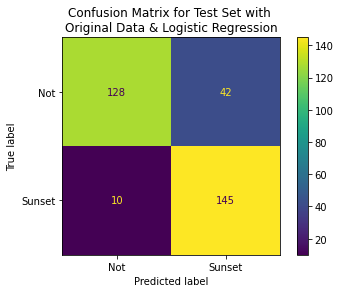

In [22]:
# make predictions from optimal grid search model - original data
y_pred = gs_original.predict(X_test_reduced)
confusion_metrics(y_pred, 'Original Data & Logistic Regression')

Scores for PCA Data & Logistic Regression
Precision score for test set: 0.616
AUC score for test set: 0.652
Accuracy score for test set: 0.649


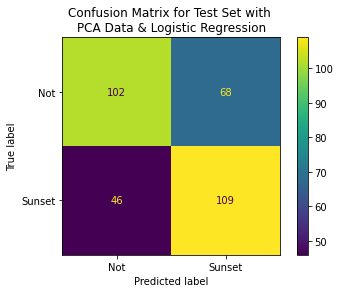

In [23]:
# make predictions from optimal grid search model - pca data
y_pred = gs_pca.predict(X_test_pca)
confusion_metrics(y_pred, 'PCA Data & Logistic Regression')

Scores for CNN Model
Precision score for test set: 0.928
AUC score for test set: 0.887
Accuracy score for test set: 0.889


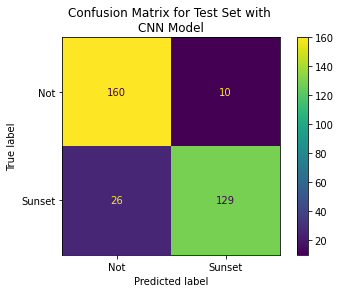

In [24]:
# make predictions from CNN with MobileNetV2 base model
X_test_reshaped = np.array(X_test).reshape(-1, 224, 224, 3)
y_pred = (cnn_model.predict(X_test_reshaped, verbose = 0) > 0.5).astype("int32")
confusion_metrics(y_pred, 'CNN Model')

#### Next Steps

There are some improvements that could be made to potentially increase the precision of the model. Firstly, we might attempt to use different variations of layers to add onto the model. I did try a couple of different numbers of dense layers before settling on the topology above, however, there are still many more combinations that could work even better. Fine tuning the last few layers of the model might also help to improve performance (though it didn't with the learning rates and layer numbers that I tested). It might also be useful to try some more different models (eg. decision trees and XGBOOST) as a comparison to those used here. Finally, after the class on SVMs, I want to try and improve my application by a) coding it from scratch and b) understanding it on a deeper level to hopefully improve the validation scores.

#### References

Acharya, H. (2017, June 9). Why my image is different being plotted in Opencv-Python? Stack Overflow. [https://stackoverflow.com/questions/44447957/why-my-image-is-different-being-plotted-in-opencv-python](https://stackoverflow.com/questions/44447957/why-my-image-is-different-being-plotted-in-opencv-python) 

Explained. (2021). Support Vector Machine (SVM) in 2 minutes [YouTube Video]. In YouTube. [https://www.youtube.com/watch?v=_YPScrckx28&ab_channel=VisuallyExplained](https://www.youtube.com/watch?v=_YPScrckx28&ab_channel=VisuallyExplained)

Kumar, S. (2021, October 30). How to tune multiple ML models with GridSearchCV at once? Medium; Towards Data Science. [https://towardsdatascience.com/how-to-tune-multiple-ml-models-with-gridsearchcv-at-once-9fcebfcc6c23](https://towardsdatascience.com/how-to-tune-multiple-ml-models-with-gridsearchcv-at-once-9fcebfcc6c23)

Luk, K. (2019, March 30). What libraries can load image in Python and what are their difference? Medium; Towards Data Science. [https://towardsdatascience.com/what-library-can-load-image-in-python-and-what-are-their-difference-d1628c6623ad](https://towardsdatascience.com/what-library-can-load-image-in-python-and-what-are-their-difference-d1628c6623ad)

Scikit-Learn. (2014). sklearn.linear_model.LogisticRegression. Scikit-Learn. [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Scikit-Learn. (2023a). 1.4. Support Vector Machines. Scikit-Learn. [https://scikit-learn.org/stable/modules/svm.html](https://scikit-learn.org/stable/modules/svm.html)

Scikit-Learn. (2023b). sklearn.svm.SVC. Scikit-Learn. [https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.htmlVisually](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.htmlVisually)

The TensorFlow Authors. (2019). Google Colaboratory. Google.com. [https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1#scrollTo=77gENRVX40S7](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1#scrollTo=77gENRVX40S7)